In [104]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [225]:
class Value:
    #Constructor
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    #This is how we define how this object is printed
    def __repr__(self):
        return f"Value(data={self.data})"
    
    #This is how we define the behavior of the `+` operator
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other),'+')

        def _backward():
            self.grad += 1.0 * out.grad #out.grad is the gradient of the parent node
            other.grad += 1.0 * out.grad #out.grad is the gradient of the parent node
        
        out._backward = _backward #give _backward() to the Value that is the result of this operation

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')

        def _backward():
            self.grad += other.data * out.grad #out.grad is the gradient of the parent node
            other.grad += self.data * out.grad #out.grad is the gradient of the parent node
        
        out._backward = _backward #give _backward() to the Value that is the result of this operation

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad #out.grad is the gradient of the parent node

        out._backward = _backward #give _backward() to the Value that is the result of this operation

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad #out.grad is the gradient of the parent node

        out._backward = _backward #give _backward() to the Value that is the result of this operation

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad #out.grad is the gradient of the parent node
        
        out._backward = _backward #give _backward() to the Value that is the result of this operation

        return out
    
    def backward(self):
        #A topological sort of the nodes of a directed graph is one such that for every edge e = (u,v), node u comes before node v.
        
        topo = []
        visited = set()

        #Here, each node adds all its children before adding itself, ensuring a topological ordering.
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad=1.0
        
        #Reversing the topological odering starts calling _backward at self, then working backward
        for node in reversed(topo):
            node._backward()

        


In [50]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

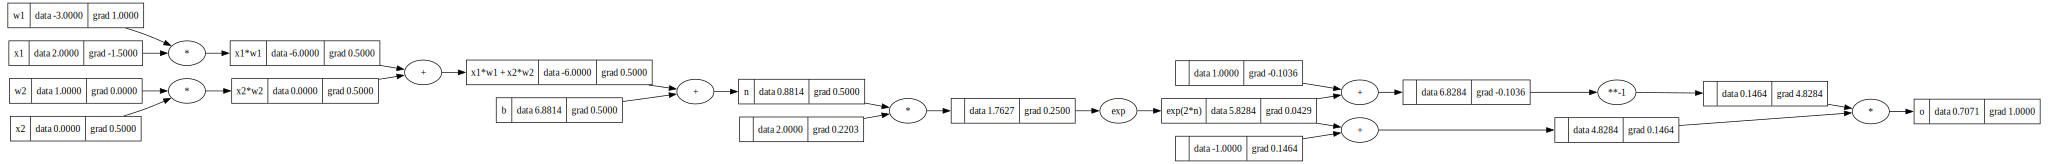

In [99]:
#One artificial neuron

#data input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'exp(2*n)'
o = (e - 1)/(e + 1); o.label = 'o'

o.backward()
draw_dot(o)

## Now the same thing but in pytorch

In [101]:
import torch

x1 = torch.Tensor([2.0]).double();                  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();                  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();                 w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();                  w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();    b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Building out a Neural Net

In [151]:
class Neuron:
    #Constructor
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    #Constructor
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    #Constructor
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [ p for layer in self.layers for p in layer.parameters()]

In [229]:
x = [2.0,3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.6034675709361583)

In [230]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [246]:
for k in range(20):

    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    #backpropegation
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 0.0009372603827854972
1 0.0009336128319544518
2 0.0009299926269434389
3 0.000926399465687949
4 0.0009228330505210015
5 0.0009192930880938404
6 0.0009157792892982774
7 0.0009122913691907158
8 0.0009088290469178794
9 0.0009053920456439869
10 0.0009019800924795322
11 0.0008985929184116238
12 0.0008952302582356973
13 0.0008918918504887208
14 0.0008885774373837334
15 0.0008852867647458784
16 0.0008820195819495679
17 0.0008787756418571686
18 0.0008755547007587327
19 0.0008723565183131682


In [247]:
ypred

[Value(data=0.9900465337260635),
 Value(data=-0.9858643905329438),
 Value(data=-0.9836822147481975),
 Value(data=0.9824728936524677)]